In [128]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

In [129]:
window_size = 200.
samples_per_window = 20

n = number of windows

`all_data`: (n, samples_per_window, 6) data (acc_x,acc_y,acc_z, gyro_x, gyro_y, gyro_z)

`has_touch`: (n,) array of +/-1 (bool for whether touch occured in this window)

`touch_loc`: (n,2) array of (x,y) touch locations

All times are adjusted so the first time in the dataset is 0.

In [138]:
dataset = "dataPixelRHandStandingRandom"
with open(dataset + ".csv") as f:
    # touch_x, touch_y, sensor, t, x, y, z = row
    csvreader = csv.reader(f)
    csvf = list(csvreader)
print(csvf[0])
start_time = int(csvf[0][3])
print("Total time (s): ", (int(csvf[-1][3]) - start_time)/1000)

['-2.0', '-2.0', 'accelerometer', '1556846706990', '0.023820243775844574', '0.19748443365097046', '0.9562157988548279']
Total time (s):  216.941


In [131]:
def normalize(arr):
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    print("Mean: ", mean)
    print("Std: ", std)
    return (arr - mean) / std

In [132]:
# Separate acc and gyro data
acc_data = np.array([[
    int(x[3]) - start_time, float(x[4]), float(x[5]), float(x[6])
] for x in csvf if x[2] == "accelerometer"])

acc_data[:, 1:] = normalize(acc_data[:, 1:])

gyro_data = np.array([[
    int(x[3]) - start_time, float(x[4]), float(x[5]), float(x[6])
] for x in csvf if x[2] == "gyroscope"])

gyro_data[:, 1:] = normalize(gyro_data[:, 1:])

end_time = max(acc_data[-1][0], gyro_data[-1][0])
num_windows = math.ceil((end_time / window_size))
num_samples = num_windows * samples_per_window
print("Total time: ", end_time)
print("Num windows:", num_windows)
print("Num samples: ", num_samples)

Mean:  [-0.06637303  0.2510089   0.97075055]
Std:  [0.12687783 0.096687   0.16449059]
Mean:  [ 0.00199213  0.00373721 -0.00024137]
Std:  [0.37695416 0.69870195 0.25791818]
Total time:  216941.0
Num windows: 1085
Num samples:  21700


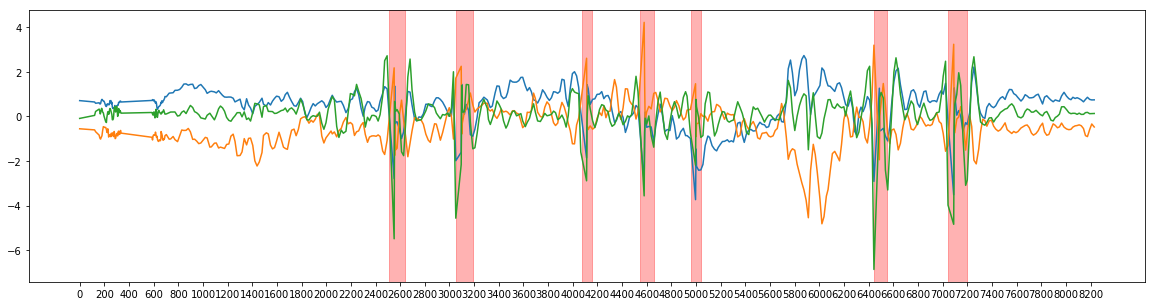

In [133]:
viewt = 500
end_time = acc_data[viewt - 1][0]
plt.plot(acc_data[:viewt, 0], acc_data[:viewt, 1])
plt.plot(acc_data[:viewt, 0], acc_data[:viewt, 2])
plt.plot(acc_data[:viewt, 0], acc_data[:viewt, 3])

presses = [int(x[3]) - start_time for x in csvf if x[2] == "press" if int(x[3]) - start_time < end_time]
releases = [int(x[3]) - start_time for x in csvf if x[2] == "release" if int(x[3]) - start_time < end_time]

presses = presses[:min(len(presses), len(releases))]

for i in range(len(presses)):
    plt.axvspan(presses[i], releases[i], alpha=0.3, color="r")
    
plt.xticks(np.arange(0, end_time, step=200))
plt.show()

In [134]:
# Interpolate
interp_times = np.linspace(0, end_time, num=num_samples)

acc_data_ts = acc_data[:,0]
# Check times all increasing
assert(np.all(np.diff(acc_data_ts) > 0))
acc_data_interp = [
    np.interp(interp_times, acc_data_ts, acc_data[:,1]),
    np.interp(interp_times, acc_data_ts, acc_data[:,2]),
    np.interp(interp_times, acc_data_ts, acc_data[:,3]),
]

gyro_data_ts = gyro_data[:,0]
assert(np.all(np.diff(gyro_data_ts) > 0))
gyro_data_interp = [
    np.interp(interp_times, gyro_data_ts, gyro_data[:,1]),
    np.interp(interp_times, gyro_data_ts, gyro_data[:,2]),
    np.interp(interp_times, gyro_data_ts, gyro_data[:,3]),
]

all_data = np.concatenate((acc_data_interp, gyro_data_interp), axis=0).T
assert(all_data.shape == (num_samples, 6))
all_data = np.array(np.split(all_data, num_windows))
assert(all_data.shape == (num_windows, samples_per_window, 6))
print("Done.")

Done.


In [141]:
# Collect touch labels
touches = np.array([[
    int(x[3]) - start_time, float(x[0]), float(x[1])
] for x in csvf])

window_end_times = np.linspace(window_size, end_time, num=num_windows)
i = 0

has_touch = []
touch_loc = []

for end_time in window_end_times:
    # Collect all samples in a window and check if any were touches
    window_has_touch = -1
    window_touch_loc = [-2, -2]
    while touches[i][0] < end_time:
        if touches[i][1] != -2:
            window_has_touch = 1
            window_touch_loc = [touches[i][1], touches[i][2]]
            break
        i += 1
    has_touch.append(window_has_touch)
    touch_loc.append(window_touch_loc)

has_touch = np.array(has_touch)
touch_loc = np.array(touch_loc)
touch_loc = normalize(touch_loc)

assert(has_touch.shape == (num_windows,))
print("Number touch windows", np.sum(has_touch == 1))
print("Number no touch windows", np.sum(has_touch == -1))
assert(touch_loc.shape == (num_windows, 2))

Mean:  [ 67.32245053 365.75455677]
Std:  [ 44.14051797 234.16478352]
Number touch windows 772
Number no touch windows 313


In [155]:
# Flatten into one feature vector before saving
all_data = all_data.reshape(-1, samples_per_window * 6)

print("all_data: ", all_data.shape)
print("has_touch: ", has_touch.shape)
print("touch_loc: ", touch_loc.shape)
np.save("processed/{}_x.npy".format(dataset), all_data)
np.save("processed/{}_has_touch_y.npy".format(dataset), has_touch)
np.save("processed/{}_touch_loc_y.npy".format(dataset), touch_loc)

all_data:  (1085, 120)
has_touch:  (1085,)
touch_loc:  (1085, 2)


# ~ machine learning ~

In [156]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

In [181]:
model = Sequential()
model.add(Dense(64, activation="relu", input_dim=(samples_per_window * 6)))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="tanh"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 64)                7744      
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 65        
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________


In [182]:
skf = StratifiedKFold(n_splits = 5)

In [185]:
accs = []
for train_idx, test_idx in skf.split(all_data, has_touch):
    x_train, x_test = all_data[train_idx], all_data[test_idx]
    y_train, y_test = has_touch[train_idx], has_touch[test_idx]
    
    model.fit(x_train, y_train, epochs=100)
    _, acc = model.evaluate(x_test, y_test)
    print("ACCURACY: ", acc)
    accs.append(acc)

Epoch 1/100
867/867 [==============================] - 0s - loss: -2.6744 - acc: 0.8593     
Epoch 2/100
867/867 [==============================] - 0s - loss: -2.9397 - acc: 0.8789     
Epoch 3/100
867/867 [==============================] - 0s - loss: -3.0264 - acc: 0.8870    
Epoch 4/100
867/867 [==============================] - 0s - loss: -3.0482 - acc: 0.8916     
Epoch 5/100
867/867 [==============================] - 0s - loss: -2.6818 - acc: 0.8662     
Epoch 6/100
867/867 [==============================] - 0s - loss: -2.0120 - acc: 0.8547     
Epoch 7/100
867/867 [==============================] - 0s - loss: -1.4403 - acc: 0.7855     
Epoch 8/100
867/867 [==============================] - 0s - loss: -2.0533 - acc: 0.8131    
Epoch 9/100
867/867 [==============================] - 0s - loss: -2.3427 - acc: 0.8316     
Epoch 10/100
867/867 [==============================] - 0s - loss: -2.1887 - acc: 0.8304     
Epoch 11/100
867/867 [==============================] - 0s - loss: -2.0

867/867 [==============================] - 0s - loss: -2.1154 - acc: 0.8293     
Epoch 89/100
867/867 [==============================] - 0s - loss: -2.3351 - acc: 0.8397     
Epoch 90/100
867/867 [==============================] - 0s - loss: -2.5574 - acc: 0.8547     
Epoch 91/100
867/867 [==============================] - 0s - loss: -2.5316 - acc: 0.8547     
Epoch 92/100
867/867 [==============================] - 0s - loss: -2.5317 - acc: 0.8454     
Epoch 93/100
867/867 [==============================] - 0s - loss: -2.6876 - acc: 0.8651     
Epoch 94/100
867/867 [==============================] - 0s - loss: -2.9933 - acc: 0.8835    
Epoch 95/100
867/867 [==============================] - 0s - loss: -3.0463 - acc: 0.8824     
Epoch 96/100
867/867 [==============================] - 0s - loss: -3.2114 - acc: 0.8835     
Epoch 97/100
867/867 [==============================] - 0s - loss: -3.1661 - acc: 0.8950     
Epoch 98/100
867/867 [==============================] - 0s - loss: -3.2475

867/867 [==============================] - 0s - loss: -3.1675 - acc: 0.8997     
Epoch 75/100
867/867 [==============================] - 0s - loss: -3.1653 - acc: 0.8985     
Epoch 76/100
867/867 [==============================] - 0s - loss: -2.4600 - acc: 0.8570     
Epoch 77/100
867/867 [==============================] - 0s - loss: -1.7621 - acc: 0.8293     
Epoch 78/100
867/867 [==============================] - 0s - loss: -3.0291 - acc: 0.8812     
Epoch 79/100
867/867 [==============================] - 0s - loss: -3.0285 - acc: 0.8893    
Epoch 80/100
867/867 [==============================] - 0s - loss: -3.0661 - acc: 0.8858     
Epoch 81/100
867/867 [==============================] - 0s - loss: -3.1632 - acc: 0.8824     
Epoch 82/100
867/867 [==============================] - 0s - loss: 2.1224 - acc: 0.7716      
Epoch 83/100
867/867 [==============================] - 0s - loss: 1.6609 - acc: 0.7174     
Epoch 84/100
867/867 [==============================] - 0s - loss: -1.2627 

868/868 [==============================] - 0s - loss: -2.9819 - acc: 0.8929     
Epoch 61/100
868/868 [==============================] - 0s - loss: -1.5606 - acc: 0.7984    
Epoch 62/100
868/868 [==============================] - 0s - loss: -1.3129 - acc: 0.7823     
Epoch 63/100
868/868 [==============================] - 0s - loss: -2.6124 - acc: 0.8641     
Epoch 64/100
868/868 [==============================] - 0s - loss: -2.8468 - acc: 0.8859     
Epoch 65/100
868/868 [==============================] - 0s - loss: -2.9443 - acc: 0.8906     
Epoch 66/100
868/868 [==============================] - 0s - loss: -2.9142 - acc: 0.8859     
Epoch 67/100
868/868 [==============================] - 0s - loss: -2.7220 - acc: 0.8813     
Epoch 68/100
868/868 [==============================] - 0s - loss: -2.7522 - acc: 0.8767     
Epoch 69/100
868/868 [==============================] - 0s - loss: -2.7188 - acc: 0.8767     
Epoch 70/100
868/868 [==============================] - 0s - loss: -2.9931

869/869 [==============================] - 0s - loss: -3.3538 - acc: 0.9125     
Epoch 46/100
869/869 [==============================] - 0s - loss: 0.5487 - acc: 0.8631      
Epoch 47/100
869/869 [==============================] - 0s - loss: -2.4900 - acc: 0.9194     
Epoch 48/100
869/869 [==============================] - 0s - loss: -2.6897 - acc: 0.9102     
Epoch 49/100
869/869 [==============================] - 0s - loss: -2.7465 - acc: 0.9160    
Epoch 50/100
869/869 [==============================] - 0s - loss: -2.8065 - acc: 0.9137     
Epoch 51/100
869/869 [==============================] - 0s - loss: -2.8452 - acc: 0.9079     
Epoch 52/100
869/869 [==============================] - 0s - loss: -2.8834 - acc: 0.9033     
Epoch 53/100
869/869 [==============================] - 0s - loss: -2.8517 - acc: 0.8907     
Epoch 54/100
869/869 [==============================] - 0s - loss: -2.8558 - acc: 0.8849     
Epoch 55/100
869/869 [==============================] - 0s - loss: -2.8528

869/869 [==============================] - 0s - loss: -1.1580 - acc: 0.8354     
Epoch 32/100
869/869 [==============================] - 0s - loss: -1.2458 - acc: 0.8389     
Epoch 33/100
869/869 [==============================] - 0s - loss: -1.3265 - acc: 0.8412        
Epoch 34/100
869/869 [==============================] - 0s - loss: -1.6505 - acc: 0.8446     
Epoch 35/100
869/869 [==============================] - 0s - loss: -2.0355 - acc: 0.8446     
Epoch 36/100
869/869 [==============================] - 0s - loss: -2.0773 - acc: 0.8481     
Epoch 37/100
869/869 [==============================] - 0s - loss: -2.2263 - acc: 0.8573     
Epoch 38/100
869/869 [==============================] - 0s - loss: -1.5597 - acc: 0.8527     
Epoch 39/100
869/869 [==============================] - 0s - loss: -1.4324 - acc: 0.8539     
Epoch 40/100
869/869 [==============================] - 0s - loss: -1.5649 - acc: 0.8573    
Epoch 41/100
869/869 [==============================] - 0s - loss: -1.7

In [186]:
np.mean(accs)

0.7490827644316742